In [1]:
# import relevant packages

%matplotlib inline

import PIL
import numpy as np
import pandas as pd
import torch
from easyimages import EasyImageList
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, log_loss
from skorch import *
from skorch.callbacks import (
    Callback,
    CyclicLR,
    Freezer,
    LRScheduler,
    PrintLog,
    scoring,
)
from skorch.utils import *
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import SGD


In [26]:
import os
os.getcwd()
#import pickle
#os.chdir('/Users/lundr/DSRCompTwo')

'C:\\Users\\lundr\\DSRCompTwo'

In [2]:
# #
# import os
# import pickle
# os.chdir('/Users/lundr/DSRCompTwo')

# # Dataframe
# path_df = "Pickles/df.pickle"
# with open(path_df, 'rb') as data:
#     df = pickle.load(data)

# # features_train
# path_features_train = "Pickles/features_train.pickle"
# with open(path_features_train, 'rb') as data:
#     features_train = pickle.load(data)

# # labels_train
# path_labels_train = "Pickles/labels_train.pickle"
# with open(path_labels_train, 'rb') as data:
#     labels_train = pickle.load(data)

# # features_test
# path_features_test = "Pickles/features_test.pickle"
# with open(path_features_test, 'rb') as data:
#     features_test = pickle.load(data)

# # labels_test
# path_labels_test = "Pickles/labels_test.pickle"
# with open(path_labels_test, 'rb') as data:
#     labels_test = pickle.load(data)

In [4]:
labels_train

176     1.0
384     0.0
856     0.0
589     0.0
674     0.0
       ... 
986     1.0
133     0.0
361     1.0
1364    0.0
451     1.0
Name: Category, Length: 1228, dtype: float64

In [5]:
#cpnvert to tensors
features_train=torch.tensor(features_train)
labels_train=torch.tensor(np.array([labels_train]).reshape(1228,1))
features_test=torch.tensor(features_test)
labels_test=torch.tensor(np.array([labels_test]).reshape(217,1))

#DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [164]:
from torch import nn
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(300, 32)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(32, 2)
        
        # Define sigmoid activation and softmax output 
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        #self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        x = self.sigmoid(x)
        

In [6]:
class BoWClassifier(nn.Module):  # inheriting from nn.Module!

    def __init__(self,num_labels, vocab_size):
        # calls the init function of nn.Module.  Dont get confused by syntax,
        # just always do it in an nn.Module
        super(BoWClassifier, self).__init__()
        
        self.layer1=nn.Sequential(
            nn.Linear(300,64),
            nn.ReLU() 
        )
        
        self.layer2=nn.Sequential(
            nn.Linear(64,64),
            nn.ReLU() 
        )
        self.layer3=nn.Sequential(
            nn.Linear(64,32),
            nn.ReLU() 
        )
        
        
        self.layer4=nn.Sequential(
            nn.Linear(32,1),
            nn.Sigmoid() 
        )
#
    def forward(self, x):
        # Pass the input through the linear layer,
        # then pass that through log_softmax.
        # Many non-linearities and other functions are in torch.nn.functional
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        return out




In [7]:
NUM_LABELS=1
VOCAB_SIZE=300
model = BoWClassifier(1,300)
model

BoWClassifier(
  (layer1): Sequential(
    (0): Linear(in_features=300, out_features=64, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [8]:


# one of ['ASGD','Adadelta', 'Adagrad','Adam', 'Adamax','LBFGS', 'RMSprop','Rprop','SGD',SparseAdam']
parameters = model.parameters()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

#model.to(DEVICE)

In [9]:
DEVICE='cpu'

In [18]:
X=features_train
Y=labels_train
N_EPOCHS = 10
loss_history = []
BATCH_SIZE = 100

net=BoWClassifier(1,300)
net = model.double() 

for epoch in range(N_EPOCHS):
    print("training epoch {}".format(epoch))
    for xsample,ysample in zip(X, Y):
         
        # zero the gradients
        # batch preparation
        
        x = xsample
        y = ysample.squeeze()

        #x = torch.Tensor(xsample).unsqueeze(0) # tensor([[0.8745, 0.5205]]) torch.Size([1, 2])
        #y = torch.Tensor([ysample]).unsqueeze(0) # tensor([[1.]]) torch.Size([1, 1])
        x = x.to(DEVICE)
        y = y.to(DEVICE)

#         What will this do once uncommented?
#         if True:
#             ix = np.random.randint(0, size=(16,), high=len(X))
#             x = torch.tensor((X[ix, :])).float()
#             y = torch.tensor(torch.Tensor(Y[ix]).reshape(-1,1)).float()
#             x = x.to(DEVICE)
#             y = y.to(DEVICE)


        # forward pass
        out =   model(x) # prediction, y_hat, 

        # loss calculation
        loss = criterion(out, y)
        # calculating gradients
        optimizer.zero_grad()
        loss.backward()
        
        # changing the weights by specified(in the optimizer init) learning rate
        optimizer.step()

        #append calculated loss to the history
        loss  = loss.detach().cpu().numpy()
        loss_history.append(loss)   
        

training epoch 0


C:\Users\lundr\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\torch\nn\modules\loss.py:498: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


training epoch 1
training epoch 2
training epoch 3
training epoch 4
training epoch 5
training epoch 6
training epoch 7
training epoch 8
training epoch 9


In [11]:
#net.layer1[0].weight

Parameter containing:
tensor([[ 0.0137, -0.0260, -0.0321,  ..., -0.0569,  0.0281,  0.0498],
        [ 0.0470, -0.0510,  0.0386,  ..., -0.0541, -0.0519, -0.0534],
        [-0.0530,  0.0414,  0.0127,  ...,  0.0510, -0.0351,  0.0532],
        ...,
        [-0.0277,  0.0484,  0.0006,  ...,  0.0517,  0.0063, -0.0028],
        [-0.0257, -0.0129, -0.0302,  ...,  0.0157, -0.0352, -0.0552],
        [ 0.0499,  0.0126, -0.0209,  ..., -0.0072,  0.0262,  0.0327]],
       dtype=torch.float64, requires_grad=True)

In [19]:
preds=[]
actual=[]
logprob = []
for instance, label in zip(features_test, labels_test):
    bow_vec = torch.tensor(instance)
    logprobs = net(bow_vec)
    #print(logprobs)
    pred=1 if logprobs>0.5 else 0
    #print('prediction: {}'.format([pred]))
    #print('actual: {}'.format(label))
    preds.append(pred)
    actual.append(label)
    logprob.append(logprobs)


C:\Users\lundr\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [20]:
preds=torch.tensor(preds, dtype=torch.float64)
actual=torch.tensor(actual,dtype=torch.float64)
#Accuracy    
#value_when_true if condition else value_when_false
correct=[]
for i in range(len(preds)):
    if preds[i] == labels_test.reshape(217,)[i]:
        correct.append(1)
    else:
        correct.append(0)
correct =sum(correct)
print("Accuracy: {:.3f}".format(correct/len(labels_test)))


Accuracy: 0.507


In [21]:
from sklearn.metrics import roc_auc_score

metric = roc_auc_score(labels_test, preds)
print(metric)

0.5048651416865824


Text(0, 0.5, 'loss (CE)')

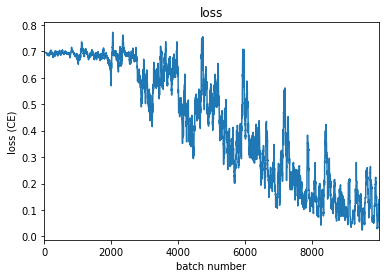

In [22]:
history = pd.DataFrame(loss_history, columns=['loss'])
history.loss[:10000].rolling(50).mean().plot()
plt.title("loss")
plt.xlabel("batch number")
plt.ylabel("loss (CE)")


